In [1]:
import itertools
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd

import json

from glob import glob
import os

from importlib import reload

import utils
import persim

import tifffile as tf
from KDEpy import FFTKDE
from scipy import ndimage,stats,spatial

In [15]:
nuclei_mask_cutoff = 1
seed = 42
ndims = 3
fs = 12
PP = 6
dpi = 96
minlife = 0.0
rng = np.random.default_rng(seed)
permmethod = stats.PermutationMethod(n_resamples=999, random_state=rng)

Cmap='plasma'
pxs = 75
pxbar = np.s_[-25:-5, 5:5 + pxs]
s = 50
alphaNmin = 0.1
alphaNmax = 10

wong = ['#d81b60', '#b5b5b5', '#6b6b6b', '#000000']
marker = ['D', '8', 's', '^', 'v', 'P', 'X', '*']
color = ['#56b4e9', '#f0e442', '#009e73', '#0072b2', '#d55e00', '#cc79a7', '#e69f00', '#e0e0e0', '#000000']
cmap = ['Blues_r', 'Wistia', 'Greens_r', 'BuPu_r', 'Oranges_r', 'RdPu_r', 'YlOrBr_r', 'gray', 'gist_gray']
box_params = {'widths':0.75, 'patch_artist':True, 'medianprops':{'lw':3, 'color':'red'} }
#figdst = os.path.expanduser('~') + '/documents/website/mcarto/figs/'
sample = 'D2'

wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
tsrc = '../translocs/'
ksrc = '../kde/'
isrc = '..' + os.sep + 'infected_focus_summer24' + os.sep 

isrc += sample + os.sep
ksrc += sample + os.sep

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv', index_col='ndimage_cellID')
metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv').set_index('gene')
cell_nuc = pd.read_csv(ksrc + sample + '_nuclei_limits.csv')
transcriptomes = np.asarray(list(metatrans['gene']))
metatrans = metatrans.set_index('gene')

Cells = utils.get_range_cell_values(isrc + 'infected_cells_ids.csv', metacell, startval=1)
Cells = np.setdiff1d( Cells, metacell[metacell['number_nuclei'] > 1].index)

Genes = utils.get_range_gene_values(isrc + 'genes_to_focus_infection.csv', transcriptomes, startval=0)
invGenes = dict(zip(Genes, range(len(Genes))))
invCells = dict(zip(Cells, range(len(Cells))))
transfocus = transcell.loc[transcriptomes[Genes], Cells.astype(str)]

level = 'sub'
normtype = 'both'
stepsize = 3
sigma = 1
pers_w = 1
pixel_size = 1

hdims = np.array([1,2])
Pname = ' [$' + ' \\oplus '.join(['H_{}'.format(k) for k in hdims]) + '$]'
pname = 'H' + '+'.join(hdims.astype(str))
SCALES = [16, 24, 32, 40, 48]
BWS = [10,15,20,25,30]

id_gene = 'GLYMA_05G203100'
full_id_gene = ''.join(id_gene)
id_gene = id_gene[-9:]

gi, gj = 0,1
pvaltol = 1e-2
o5glabels = ['All', 'w/ '+id_gene, 'w/o '+id_gene]

fivegcolumns = []
for j in [gi, gj]:
    for k in range(2):
        for t in ['KS', 'MW', 'Anderson']:
            foo = 'w_vs_wo_{}_-_PC{}_-_{}_-_{}_pval'.format(id_gene[-9:], k+1, transcriptomes[Genes[j]][-9:], t)
            fivegcolumns.append(foo)

for w in ['all', 'w_'+id_gene,'wo_'+id_gene]:
    for it in itertools.product(range(2), repeat=2):
        for t in ['rho', 'pval']:
            foo = '{}_-_{}_PC{}_-_vs_-_{}_PC{}_-_spearman_{}'.format(w, transcriptomes[Genes[gi]][-9:], it[0]+1, transcriptomes[Genes[gj]][-9:], it[1]+1, t)
            fivegcolumns.append(foo)

for w in ['all', 'w_'+id_gene,'wo_'+id_gene]:
    for j, gidx in enumerate([gi,gj]):
        for k in range(2):
            for t in ['rho', 'pval']:
                foo = '{}_-_ecc_-_vs_-_{}_PC{}_-_spearman_{}'.format(w, transcriptomes[Genes[gidx]][-9:], k+1, t)
                fivegcolumns.append(foo)
                
dfs = dict()
for scale in SCALES:
    for bw in BWS:
        foo = [len(Genes), level, normtype, stepsize, bw, scale, sigma, pers_w, pixel_size, pname]
        filename = isrc + 'G{}_{}level_{}_step{}_bw{}/scale{}_-_PI_{}_{}_{}_{}'.format(*foo)
        filename += '_{}_{}_pca_{}.csv'.format(*transcriptomes[Genes[[gi,gj]]], full_id_gene)
        dfs[(scale, bw)] = pd.read_csv(filename, header=None, names=fivegcolumns)

In [29]:
for i in range(len(fivegcolumns)):
    print(i, fivegcolumns[i], sep='\t')

0	w_vs_wo_05G203100_-_PC1_-_17G195900_-_KS_pval
1	w_vs_wo_05G203100_-_PC1_-_17G195900_-_MW_pval
2	w_vs_wo_05G203100_-_PC1_-_17G195900_-_Anderson_pval
3	w_vs_wo_05G203100_-_PC2_-_17G195900_-_KS_pval
4	w_vs_wo_05G203100_-_PC2_-_17G195900_-_MW_pval
5	w_vs_wo_05G203100_-_PC2_-_17G195900_-_Anderson_pval
6	w_vs_wo_05G203100_-_PC1_-_05G092200_-_KS_pval
7	w_vs_wo_05G203100_-_PC1_-_05G092200_-_MW_pval
8	w_vs_wo_05G203100_-_PC1_-_05G092200_-_Anderson_pval
9	w_vs_wo_05G203100_-_PC2_-_05G092200_-_KS_pval
10	w_vs_wo_05G203100_-_PC2_-_05G092200_-_MW_pval
11	w_vs_wo_05G203100_-_PC2_-_05G092200_-_Anderson_pval
12	all_-_17G195900_PC1_-_vs_-_05G092200_PC1_-_spearman_rho
13	all_-_17G195900_PC1_-_vs_-_05G092200_PC1_-_spearman_pval
14	all_-_17G195900_PC1_-_vs_-_05G092200_PC2_-_spearman_rho
15	all_-_17G195900_PC1_-_vs_-_05G092200_PC2_-_spearman_pval
16	all_-_17G195900_PC2_-_vs_-_05G092200_PC1_-_spearman_rho
17	all_-_17G195900_PC2_-_vs_-_05G092200_PC1_-_spearman_pval
18	all_-_17G195900_PC2_-_vs_-_05G092200_P

In [26]:
scale, bw = 32,20
key = (scale, bw)
dfs[key].head()

,w_vs_wo_05G203100_-_PC1_-_17G195900_-_KS_pval,w_vs_wo_05G203100_-_PC1_-_17G195900_-_MW_pval,w_vs_wo_05G203100_-_PC1_-_17G195900_-_Anderson_pval,w_vs_wo_05G203100_-_PC2_-_17G195900_-_KS_pval,w_vs_wo_05G203100_-_PC2_-_17G195900_-_MW_pval,w_vs_wo_05G203100_-_PC2_-_17G195900_-_Anderson_pval,w_vs_wo_05G203100_-_PC1_-_05G092200_-_KS_pval,w_vs_wo_05G203100_-_PC1_-_05G092200_-_MW_pval,w_vs_wo_05G203100_-_PC1_-_05G092200_-_Anderson_pval,w_vs_wo_05G203100_-_PC2_-_05G092200_-_KS_pval,...,w_05G203100_-_ecc_-_vs_-_05G092200_PC2_-_spearman_rho,w_05G203100_-_ecc_-_vs_-_05G092200_PC2_-_spearman_pval,wo_05G203100_-_ecc_-_vs_-_17G195900_PC1_-_spearman_rho,wo_05G203100_-_ecc_-_vs_-_17G195900_PC1_-_spearman_pval,wo_05G203100_-_ecc_-_vs_-_17G195900_PC2_-_spearman_rho,wo_05G203100_-_ecc_-_vs_-_17G195900_PC2_-_spearman_pval,wo_05G203100_-_ecc_-_vs_-_05G092200_PC1_-_spearman_rho,wo_05G203100_-_ecc_-_vs_-_05G092200_PC1_-_spearman_pval,wo_05G203100_-_ecc_-_vs_-_05G092200_PC2_-_spearman_rho,wo_05G203100_-_ecc_-_vs_-_05G092200_PC2_-_spearman_pval
0,0.021864,0.003174,0.007,0.001771,0.062973,0.007,0.002493,0.000188,0.001,0.289803,...,0.343478,1.175780e-13,0.248393,3.860144e-08,0.386195,2.051348e-18,0.049760,0.278103,0.292757,7.005365e-11
1,0.000556,0.000179,0.001,0.000412,0.042797,0.004,0.008571,0.000491,0.003,0.213234,...,0.338879,6.332357e-09,0.253286,8.228227e-11,0.391100,8.735287e-25,0.066656,0.092270,0.307332,1.913972e-15
2,0.026475,0.028599,0.025,0.090630,0.207548,0.164,0.044155,0.006623,0.013,0.017567,...,0.331864,1.680930e-06,0.232264,2.909282e-10,0.420332,3.794422e-32,0.058871,0.114752,0.312111,1.040153e-17
3,0.366242,0.259158,0.278,0.186288,0.233651,0.220,0.017879,0.007587,0.004,0.049739,...,0.308784,1.343143e-04,0.225927,2.279941e-10,0.423535,7.241614e-35,0.071762,0.046521,0.317177,1.864663e-19
4,0.768300,0.795496,0.456,0.077201,0.110701,0.065,0.132855,0.048119,0.058,0.257712,...,0.255769,3.844715e-03,0.224625,1.622372e-10,0.419088,4.959628e-35,0.074092,0.037096,0.326804,3.620344e-21


In [50]:
def ratio_ab(a,b):
    return (np.abs(b) - np.abs(a))/np.abs(a)

def print_results(dfs, key, min5G):
    all_rho1 = dfs[key].loc[min5G, 'all_-_17G195900_PC1_-_vs_-_05G092200_PC1_-_spearman_rho']
    w_rho1 = dfs[key].loc[min5G, 'w_05G203100_-_17G195900_PC1_-_vs_-_05G092200_PC1_-_spearman_rho']
    wo_rho1 = dfs[key].loc[min5G, 'wo_05G203100_-_17G195900_PC1_-_vs_-_05G092200_PC1_-_spearman_rho']
    foo1 = ratio_ab(all_rho1, w_rho1)

    all_rho2 = dfs[key].loc[min5G, 'all_-_17G195900_PC2_-_vs_-_05G092200_PC2_-_spearman_rho']
    w_rho2 = dfs[key].loc[min5G, 'w_05G203100_-_17G195900_PC2_-_vs_-_05G092200_PC2_-_spearman_rho']
    wo_rho2 = dfs[key].loc[min5G, 'wo_05G203100_-_17G195900_PC2_-_vs_-_05G092200_PC2_-_spearman_rho']
    foo2 = ratio_ab(all_rho2, w_rho2)

    all_ecc11 = dfs[key].loc[min5G, 'all_-_ecc_-_vs_-_17G195900_PC1_-_spearman_rho']
    w_ecc11 = dfs[key].loc[min5G, 'w_05G203100_-_ecc_-_vs_-_17G195900_PC1_-_spearman_rho']
    wo_ecc11 = dfs[key].loc[min5G, 'wo_05G203100_-_ecc_-_vs_-_17G195900_PC1_-_spearman_rho']
    foo11 = ratio_ab(all_ecc11, w_ecc11)
    
    all_ecc12 = dfs[key].loc[min5G, 'all_-_ecc_-_vs_-_17G195900_PC2_-_spearman_rho']
    w_ecc12 = dfs[key].loc[min5G, 'w_05G203100_-_ecc_-_vs_-_17G195900_PC2_-_spearman_rho']
    wo_ecc12 = dfs[key].loc[min5G, 'wo_05G203100_-_ecc_-_vs_-_17G195900_PC2_-_spearman_rho']
    foo12 = ratio_ab(all_ecc12, w_ecc12)

    all_ecc21 = dfs[key].loc[min5G, 'all_-_ecc_-_vs_-_05G092200_PC1_-_spearman_rho']
    w_ecc21 = dfs[key].loc[min5G, 'w_05G203100_-_ecc_-_vs_-_05G092200_PC1_-_spearman_rho']
    wo_ecc21 = dfs[key].loc[min5G, 'wo_05G203100_-_ecc_-_vs_-_05G092200_PC1_-_spearman_rho']
    foo21 = ratio_ab(all_ecc21, w_ecc21)

    all_ecc22 = dfs[key].loc[min5G, 'all_-_ecc_-_vs_-_05G092200_PC2_-_spearman_rho']
    w_ecc22 = dfs[key].loc[min5G, 'w_05G203100_-_ecc_-_vs_-_05G092200_PC2_-_spearman_rho']
    wo_ecc22 = dfs[key].loc[min5G, 'wo_05G203100_-_ecc_-_vs_-_05G092200_PC2_-_spearman_rho']
    foo22 = ratio_ab(all_ecc22, w_ecc22)
    
    print(key, np.round([all_rho1, w_rho1, foo1],2), np.round([all_rho2, w_rho2, foo2],2), np.round([all_ecc12, w_ecc12, foo12],2), np.round([all_ecc22, w_ecc22, foo22],2), sep='\t')

In [53]:
min5G = 0
for scale in SCALES:
    for bw in BWS:
        key = (scale, bw)
        print_results(dfs, key, min5G)

(16, 10)	[ 0.75  0.72 -0.04]	[-0.41 -0.38 -0.07]	[0.2  0.21 0.07]	[0.05 0.07 0.49]
(16, 15)	[ 0.62  0.58 -0.07]	[ 0.27  0.27 -0.02]	[0.18 0.2  0.11]	[0.11 0.16 0.48]
(16, 20)	[ 0.57  0.53 -0.08]	[0.21 0.24 0.17]	[0.39 0.41 0.05]	[0.32 0.36 0.13]
(16, 25)	[ 0.53  0.48 -0.09]	[0.23 0.25 0.11]	[0.42 0.43 0.03]	[0.32 0.36 0.14]
(16, 30)	[ 0.49  0.45 -0.08]	[0.23 0.25 0.11]	[0.44 0.45 0.01]	[0.29 0.34 0.15]
(24, 10)	[0.16 0.2  0.24]	[ 0.51  0.46 -0.08]	[0.43 0.45 0.03]	[0.18 0.19 0.05]
(24, 15)	[ 0.52  0.49 -0.07]	[0.23 0.27 0.16]	[-0.33 -0.34  0.05]	[-0.21 -0.25  0.17]
(24, 20)	[ 0.53  0.5  -0.06]	[0.19 0.23 0.16]	[0.4  0.43 0.05]	[0.31 0.35 0.11]
(24, 25)	[ 0.51  0.48 -0.06]	[0.22 0.24 0.12]	[0.45 0.46 0.03]	[0.32 0.36 0.11]
(24, 30)	[ 0.48  0.46 -0.04]	[0.23 0.24 0.07]	[0.44 0.45 0.01]	[0.31 0.35 0.12]
(32, 10)	[0.06 0.1  0.6 ]	[ 0.33  0.31 -0.05]	[ 0.54  0.53 -0.02]	[0.24 0.25 0.05]
(32, 15)	[ 0.44  0.41 -0.06]	[0.19 0.24 0.25]	[-0.41 -0.44  0.09]	[-0.27 -0.3   0.1 ]
(32, 20)	[ 0.49  0.

In [54]:
for bw in BWS:
    for scale in SCALES:
        key = (scale, bw)
        print_results(dfs, key, min5G)

(16, 10)	[ 0.75  0.72 -0.04]	[-0.41 -0.38 -0.07]	[0.2  0.21 0.07]	[0.05 0.07 0.49]
(24, 10)	[0.16 0.2  0.24]	[ 0.51  0.46 -0.08]	[0.43 0.45 0.03]	[0.18 0.19 0.05]
(32, 10)	[0.06 0.1  0.6 ]	[ 0.33  0.31 -0.05]	[ 0.54  0.53 -0.02]	[0.24 0.25 0.05]
(40, 10)	[0.02 0.06 1.46]	[ 0.29  0.28 -0.03]	[ 0.55  0.53 -0.03]	[0.26 0.27 0.05]
(48, 10)	[0.01 0.05 2.66]	[ 0.26  0.25 -0.01]	[ 0.55  0.53 -0.03]	[0.25 0.27 0.06]
(16, 15)	[ 0.62  0.58 -0.07]	[ 0.27  0.27 -0.02]	[0.18 0.2  0.11]	[0.11 0.16 0.48]
(24, 15)	[ 0.52  0.49 -0.07]	[0.23 0.27 0.16]	[-0.33 -0.34  0.05]	[-0.21 -0.25  0.17]
(32, 15)	[ 0.44  0.41 -0.06]	[0.19 0.24 0.25]	[-0.41 -0.44  0.09]	[-0.27 -0.3   0.1 ]
(40, 15)	[ 0.4   0.38 -0.04]	[0.16 0.22 0.35]	[-0.41 -0.46  0.12]	[-0.31 -0.33  0.06]
(48, 15)	[ 0.37  0.36 -0.02]	[0.1  0.17 0.8 ]	[-0.35 -0.42  0.18]	[-0.34 -0.35  0.03]
(16, 20)	[ 0.57  0.53 -0.08]	[0.21 0.24 0.17]	[0.39 0.41 0.05]	[0.32 0.36 0.13]
(24, 20)	[ 0.53  0.5  -0.06]	[0.19 0.23 0.16]	[0.4  0.43 0.05]	[0.31 0.35 0.11]
(

In [56]:
min5G = 3
Gname = ' {}$\geq${}.'.format(full_id_gene, 1+min5G)
O5G = (transcell.loc[full_id_gene, Cells.astype(str)] > min5G).values
nonO5G = (transcell.loc[full_id_gene, Cells.astype(str)] <= min5G).values
print(np.sum(O5G), np.sum(nonO5G))

148 770


../infected_focus_summer24/D2/G2_sublevel_both_step3_bw30/scale16_-_PI_1_1_1_H1+2_4_GLYMA_17G195900_GLYMA_05G092200_pca_GLYMA_05G203100


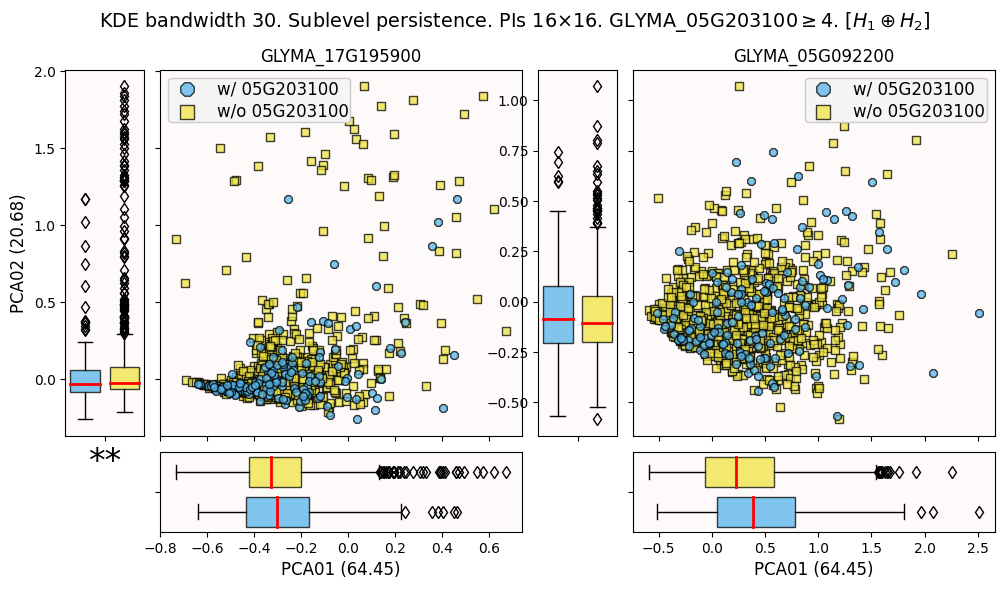

In [57]:
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(5, 10, figure=fig)
fig.add_subplot(gs[:4, 1:5]); fig.add_subplot(gs[:4, 6:])
for i in [0,5]:
    fig.add_subplot(gs[4, i+1:i+5])
    fig.add_subplot(gs[:4, i])
    
for i in range(len(Genes)):
    fig.axes[i].set_title(transcriptomes[Genes[i]], fontsize=fs)
    for j,mask in enumerate([O5G, nonO5G]):
        foo = embedding[embedding['gene_ID'] == Genes[i]].iloc[mask, 2:4]
        fig.axes[i].scatter(*(foo.T.values), marker=marker[j+1], color=color[j], edgecolor='k', label=o5glabels[j+1], alpha=0.75, zorder=2-j)
    fig.axes[i].legend(fontsize=fs, framealpha=1, markerscale=1.75, borderpad=0.1, labelspacing=0.25, facecolor='whitesmoke')
    fig.axes[i].tick_params(bottom=True, labelbottom=False, left=True, labelleft=False)

for i in range(2):
    foo = [ embedding[embedding['gene_ID'] == Genes[i]].iloc[mask, 2:4].values for mask in [O5G, nonO5G] ]
    for j in range(2):
        bplot = fig.axes[2*i + 2+j].boxplot([ bar[:,j] for bar in foo ], sym='d', vert=bool(j), widths=0.75, patch_artist=True, labels=['',''], medianprops={'lw':2,'c':'r'})
        for patch, c in zip(bplot['boxes'], color[:2]):
            patch.set_facecolor(c)
            patch.set_alpha(0.75)
        #fig.axes[2*i + 2+j].tick_params(labelsize=fs)
    fig.axes[2*i+3].set_xticks([1.5], ['*' * (fivegdata.iloc[min5G, 3+6*i: 3+6*i+3] < pvaltol).sum()], fontsize=2*fs, ha='center', va='top')
    fig.axes[2*i+2].set_yticks([1.5], ['*' * (fivegdata.iloc[min5G, 6*i: 6*i+3] < pvaltol).sum()], rotation=90, fontsize=2*fs, ha='center', va='center')
    fig.axes[2*i+2].set_xlabel(embedding.columns[2], fontsize=fs)
    
fig.axes[3].set_ylabel(embedding.columns[3], fontsize=fs)
fig.suptitle(Bname + Gname + Pname , fontsize=1.15*fs)

for i in range(len(fig.axes)):
    fig.axes[i].set_facecolor('snow')

filename = dsrc + bname + pname + '_{}_{}_{}_pca_{}'.format(min5G+1, *transcriptomes[Genes[[gi,gj]]], full_id_gene)
print(filename)

../infected_focus_summer24/D2/G2_sublevel_both_step3_bw30/scale16_-_PI_1_1_1_H1+2_4_GLYMA_17G195900_GLYMA_05G092200_pc_vs_pc_GLYMA_05G203100


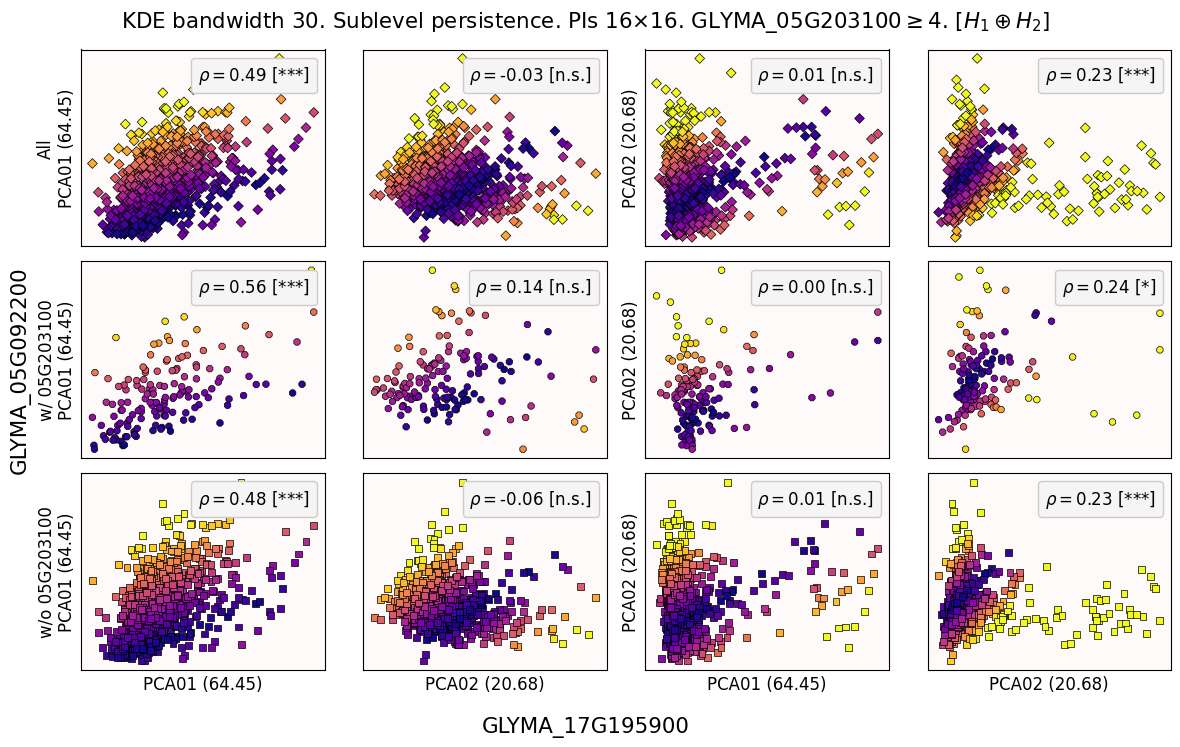

In [58]:
fig, ax = plt.subplots(3,4, figsize=(12,7.5), sharex=False, sharey=False)
for i in range(4):
    ax[-1,i].set_xlabel(embedding.columns[2+i%2], fontsize=fs)

ct = 0
for j,mask in enumerate([np.ones(len(merge),dtype=bool), O5G, nonO5G]):
    ax[j,0].set_ylabel(o5glabels[j] + '\n' +embedding.columns[2], fontsize=fs)
    ax[j,2].set_ylabel(embedding.columns[3], fontsize=fs)
    for it in itertools.product(range(2), repeat=2):
        k = 2*it[0] + it[1]
        
        pca_comp = merge.loc[mask, [ embedding.columns[2 + it[i]]+'_{}'.format(i) for i in range(2)] ]
        diff = np.abs(np.subtract(*(pca_comp.T.values)))
        vmin = utils.minimum_qq_size( diff, alpha=0.25, iqr_factor=1.5)
        vmax = utils.maximum_qq_size( diff, alpha=0.25, iqr_factor=1.5)
        
        corr = fivegdata.iloc[min5G, 12+2*ct]
        expo = utils.signifscalar(fivegdata.iloc[min5G, 12+2*ct+1])
        ct += 1
        ll = '$\\rho = ${:.2f} [{}]'.format(corr, expo)
            
        ax[j,k].scatter(pca_comp.iloc[:,0], pca_comp.iloc[:,1], c=diff, cmap='plasma', marker=marker[j],
                         edgecolor='black', linewidth=0.5, zorder=2, s=25, vmin=vmin, vmax=vmax, label=ll)
        ax[j,k].legend(fontsize=fs, handlelength=0, handletextpad=0, loc='upper right', markerscale=0, framealpha=1, facecolor='whitesmoke')

for a in ax.ravel():
    a.set_facecolor('snow')
    a.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

fig.supxlabel(transcriptomes[Genes[gi]], fontsize=1.28*fs)
fig.supylabel(transcriptomes[Genes[gj]], fontsize=1.28*fs)
fig.suptitle(Bname + Gname + Pname , fontsize=1.28*fs)

fig.tight_layout();
filename = dsrc + bname + pname + '_{}_{}_{}_pc_vs_pc_{}'.format(min5G+1, *transcriptomes[Genes[[gi,gj]]], full_id_gene)
print(filename)
#plt.savefig(filename, dpi=dpi, bbox_inches='tight', pil_kwargs={'optimize':True})

../infected_focus_summer24/D2/G2_sublevel_both_step3_bw30/scale16_-_PI_1_1_1_H1+2_1_GLYMA_17G195900_GLYMA_05G092200_ecc_GLYMA_05G203100


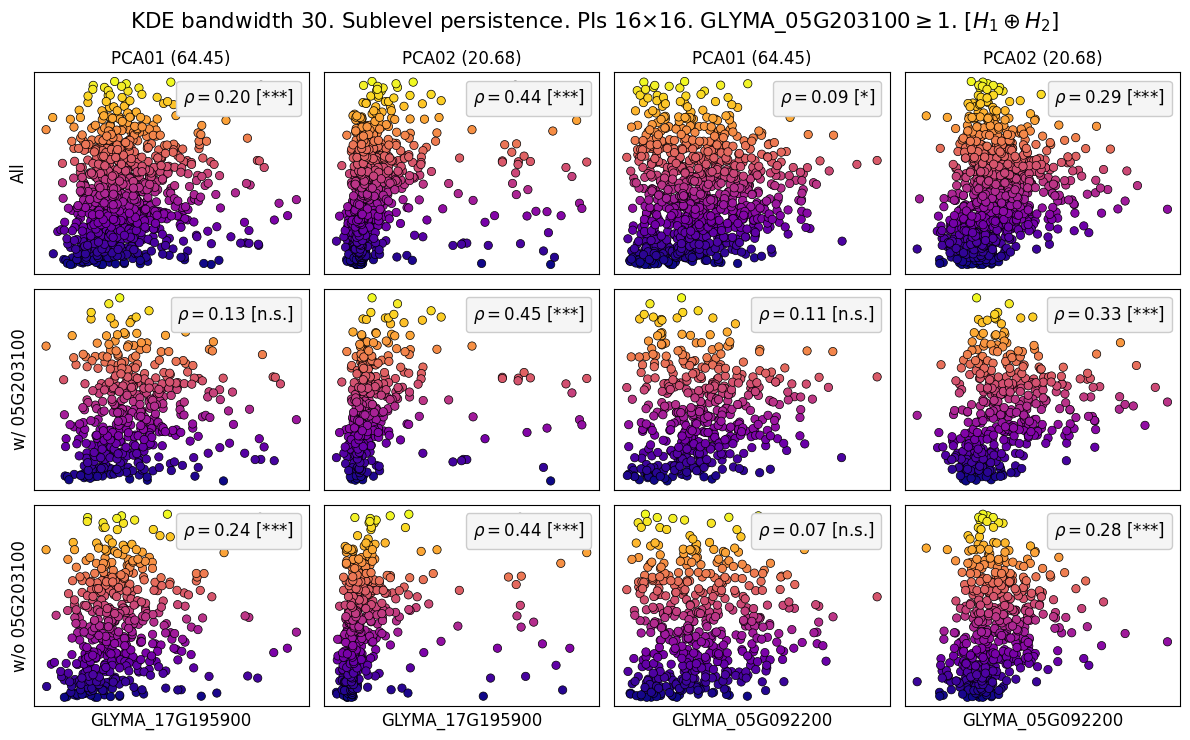

In [54]:
fig, ax = plt.subplots(3,4, figsize=(12,7.5), sharex=False, sharey=False)

for j, gidx in enumerate([gi,gj]):
    for k in range(2):
        it = (0 , 2*j+k)
        ax[it].set_title(embedding.columns[2+k], fontsize=fs)
        ax[-1, 2*j+k].set_xlabel(transcriptomes[Genes[gidx]], fontsize=fs)
ct = 0
for i,mask in enumerate([np.ones(len(merge),dtype=bool), O5G, nonO5G]):
    ax[i,0].set_ylabel(o5glabels[i], fontsize=fs)
    for j, gidx in enumerate([gi,gj]):
        pmask = embedding['gene_ID'] == Genes[gidx]
        for k in range(2):
            it = (i , 2*j+k)
            c = pca[pmask, k][mask]
            diff = np.abs(np.subtract(c, ecc[mask]))
            corr = fivegdata.iloc[min5G, 36+2*ct]
            expo = utils.signifscalar(fivegdata.iloc[min5G, 36+2*ct+1])
            ct += 1
            ll = '$\\rho = ${:.2f} [{}]'.format(corr, expo)
            ax[it].scatter(c, ecc[mask], c=diff, cmap=Cmap, marker='o', edgecolor='black', linewidth=0.5, label=ll)
            ax[it].legend(fontsize=fs, handlelength=0, handletextpad=0, loc='upper right', markerscale=0, framealpha=1, facecolor='whitesmoke')
            ax[it].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

fig.suptitle(Bname + Gname + Pname , fontsize=1.28*fs)

fig.tight_layout();
filename = dsrc + bname + pname + '_{}_{}_{}_ecc_{}'.format(min5G+1, *transcriptomes[Genes[[gi,gj]]], full_id_gene)
print(filename)
#plt.savefig(filename, dpi=dpi, bbox_inches='tight', pil_kwargs={'optimize':True})

In [249]:
bname

'scale24_-_PI_1_1_1_'

In [252]:

filename

'../infected_focus_summer24/D2/G2_sublevel_both_step3_bw15/scale24_-_PI_1_1_1_H1+2_GLYMA_17G195900_GLYMA_05G092200_ecc_GLYMA_05G203100'

# Explore